## Market Customer Segmentation

In [1]:
!pip install scikit-learn-extra

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn_extra.cluster import KMedoids

import warnings
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_excel('Credit Card Customer Data.xlsx')

data.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


In [5]:
data.nunique()

Sl_No                  660
Customer Key           655
Avg_Credit_Limit       110
Total_Credit_Cards      10
Total_visits_bank        6
Total_visits_online     16
Total_calls_made        11
dtype: int64

### Data Preprocessing

In [6]:
# Drop duplicate keys
duplicate_keys = data['Customer Key'].duplicated()

data = data[~duplicate_keys]

data['Customer Key'].duplicated().sum()

0

In [7]:
# Drop unnecessary columns
data.drop(columns = ['Sl_No', 'Customer Key'], inplace = True)

In [8]:
# Drop duplicate rows
data[data.duplicated()]
data = data[~data.duplicated()]
data[data.duplicated()].sum()

Avg_Credit_Limit       0.0
Total_Credit_Cards     0.0
Total_visits_bank      0.0
Total_visits_online    0.0
Total_calls_made       0.0
dtype: float64

In [9]:
data.shape

(644, 5)

### Exploratory Data Analysis

In [10]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,644.0,34543.478261,37428.704286,3000.0,11000.0,18000.0,48000.00,200000.0
Total_Credit_Cards,644.0,4.694099,2.175338,1.0,3.0,5.0,6.00,10.0
Total_visits_bank,644.0,2.395963,1.626964,0.0,1.0,2.0,4.00,5.0
Total_visits_online,644.0,2.624224,2.957728,0.0,1.0,2.0,4.00,15.0
Total_calls_made,644.0,3.608696,2.880025,0.0,1.0,3.0,5.25,10.0


Avg_Credit_Limit
Skew : 2.19


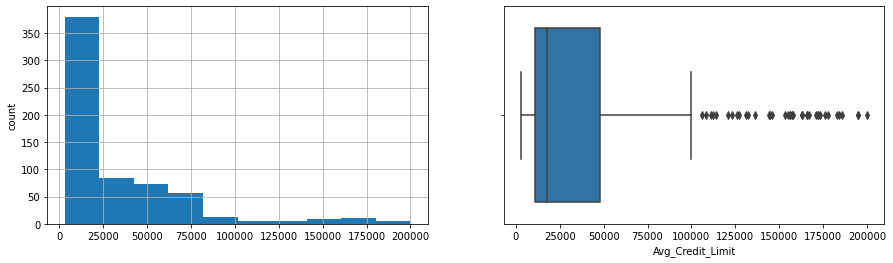

Total_Credit_Cards
Skew : 0.17


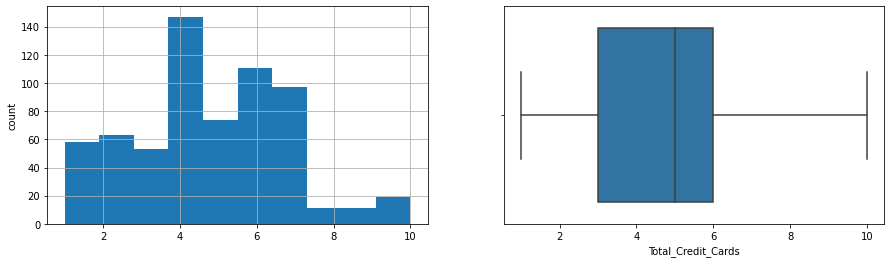

Total_visits_bank
Skew : 0.15


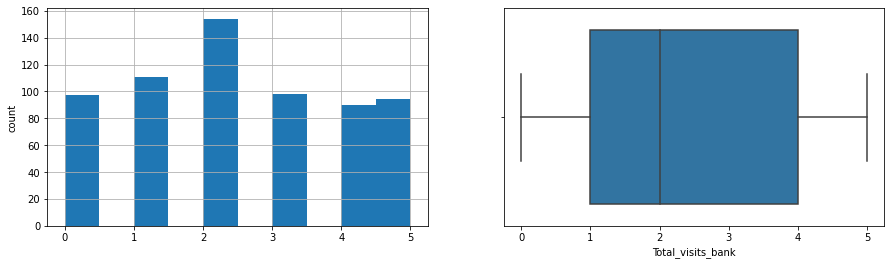

Total_visits_online
Skew : 2.21


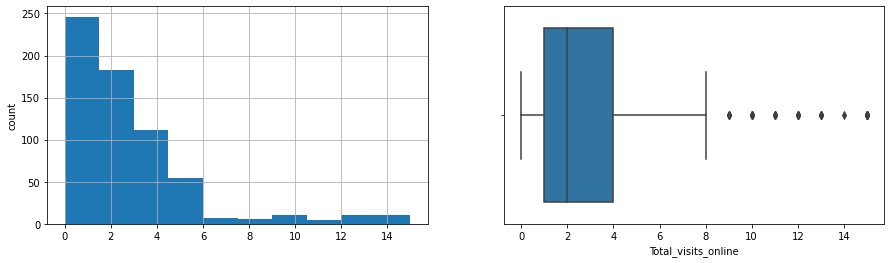

Total_calls_made
Skew : 0.65


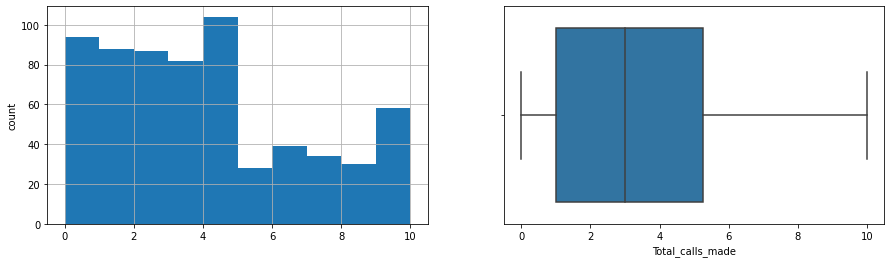

In [11]:
# Checking distribution of variable and for outliers
for col in data.columns:
    print(col)
    
    print('Skew :', round(data[col].skew(), 2))
    
    plt.figure(figsize = (15, 4))
    
    plt.subplot(1, 2, 1)
    
    data[col].hist()
    
    plt.ylabel('count')
    
    plt.subplot(1, 2, 2)
    
    sns.boxplot(x = data[col])
    
    plt.show()

### **Checking correlation**

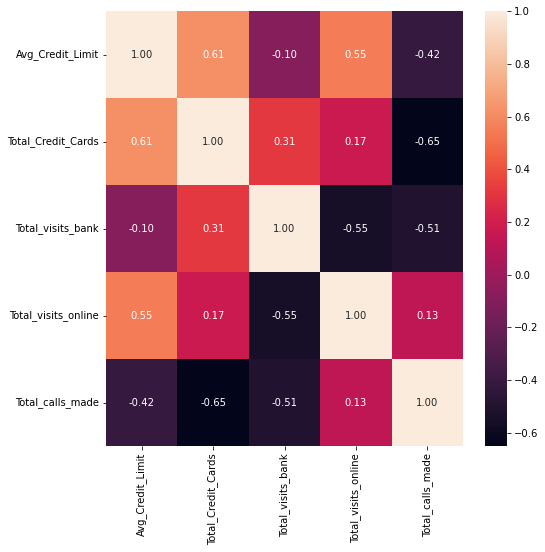

In [12]:
#Checking correlations of variables
plt.figure(figsize = (8, 8))

sns.heatmap(data.corr(), annot = True, fmt = '0.2f')

plt.show()

### PCA

In [13]:
# Standardizing data to have a mean of ~0 and a variance of 1
scaler = StandardScaler()

data_scaled = StandardScaler().fit_transform(data)

In [14]:
from sklearn.decomposition import PCA

n = data.shape[1]

# Creating PCA instance
pca = PCA(n_components=n)

principal_components = pca.fit_transform(data_scaled)

# Saving components to a DataFrame
data_pca = pd.DataFrame(principal_components, columns = data.columns)

In [15]:
# Creating copy of data to store labels from each algorithm
data_copy = data_pca.copy(deep = True)

### K-Means Clustering

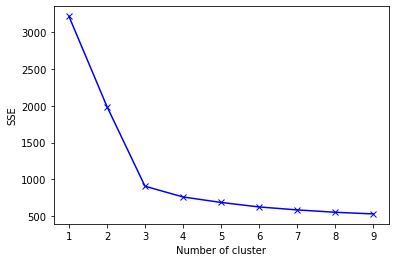

In [16]:
# Initialize dictionary to store SSE for each K
sse = {} 

# Iterating a range of Ks and fitting the pca components to the algorithm. 
for k in range(1, 10):
    kmeans = KMeans(n_clusters = k, max_iter = 1000, random_state = 1).fit(data_pca)
    sse[k] = kmeans.inertia_

# Plotting SSE vs K elbow curve
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()), 'bx-')
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [17]:
# Fitting K-means algorithm on PCA components with K=3
kmeans = KMeans(n_clusters = 3, random_state = 1)
kmeans.fit(data_copy)

# Saving prediction labels to original and copied data
data_copy['Labels'] = kmeans.labels_
data['Labels'] = kmeans.labels_

In [18]:
# Number of observations in each cluster
data.Labels.value_counts()

1    374
0    221
2     49
Name: Labels, dtype: int64

In [19]:
# Summary statistics of the original data for each label
mean = data.groupby('Labels').mean()

median = data.groupby('Labels').median()

df_kmeans = pd.concat([mean, median], axis = 0)

df_kmeans.index = ['group_0 Mean', 'group_1 Mean', 'group_2 Mean', 'group_0 Median', 'group_1 Median', 'group_2 Median']

df_kmeans.T

,group_0 Mean,group_1 Mean,group_2 Mean,group_0 Median,group_1 Median,group_2 Median
Avg_Credit_Limit,12239.819005,33893.048128,140102.040816,12000.0,31500.0,145000.0
Total_Credit_Cards,2.411765,5.508021,8.775510,2.0,6.0,9.0
Total_visits_bank,0.945701,3.489305,0.591837,1.0,3.0,1.0
Total_visits_online,3.561086,0.975936,10.979592,4.0,1.0,11.0
Total_calls_made,6.891403,1.997326,1.102041,7.0,2.0,1.0


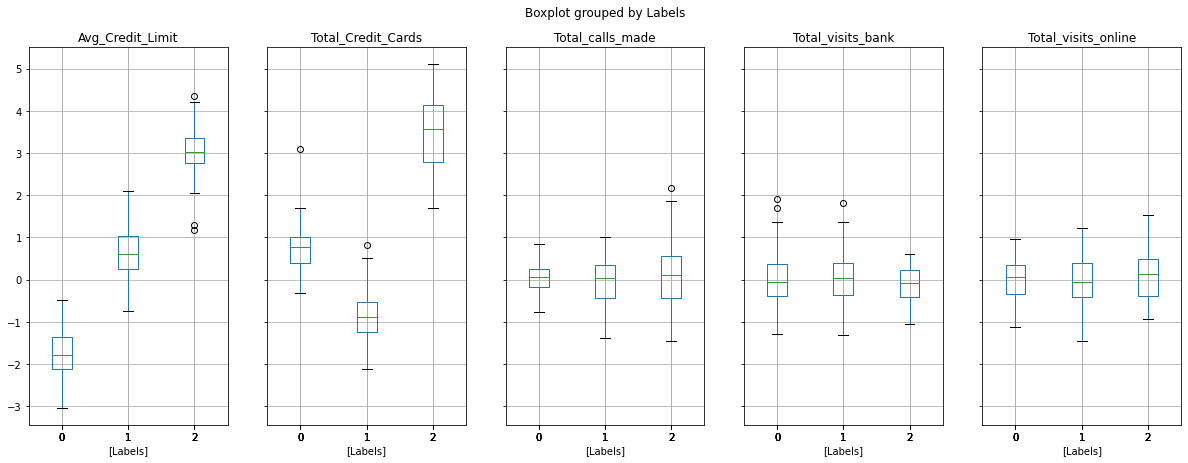

In [20]:
# Visualizing different features w.r.t K-means labels
data_copy.boxplot(by = 'Labels', layout = (1, 5), figsize = (20, 7))

plt.show()

### Gaussian Mixture Model

In [21]:
# Apply the Gaussian Mixture algorithm on the pca components
gmm = GaussianMixture(n_components = 3, random_state = 1)

gmm.fit(data_pca)

data_copy['GmmLabels'] = gmm.predict(data_pca)

data['GmmLabels'] = gmm.predict(data_pca)

In [22]:
# Number of observations in each cluster
data.GmmLabels.value_counts()

1    374
0    221
2     49
Name: GmmLabels, dtype: int64

In [23]:
# Calculating the summary statistics of the original data for each label
original_features = ["Avg_Credit_Limit", "Total_Credit_Cards", "Total_visits_bank", "Total_visits_online", "Total_calls_made"]

mean = data.groupby('GmmLabels').mean()

median = data.groupby('GmmLabels').median()

df_gmm = pd.concat([mean, median], axis = 0)

df_gmm.index = ['group_0 Mean', 'group_1 Mean', 'group_2 Mean', 'group_0 Median', 'group_1 Median', 'group_2 Median']

df_gmm[original_features].T

,group_0 Mean,group_1 Mean,group_2 Mean,group_0 Median,group_1 Median,group_2 Median
Avg_Credit_Limit,12239.819005,33893.048128,140102.040816,12000.0,31500.0,145000.0
Total_Credit_Cards,2.411765,5.508021,8.775510,2.0,6.0,9.0
Total_visits_bank,0.945701,3.489305,0.591837,1.0,3.0,1.0
Total_visits_online,3.561086,0.975936,10.979592,4.0,1.0,11.0
Total_calls_made,6.891403,1.997326,1.102041,7.0,2.0,1.0


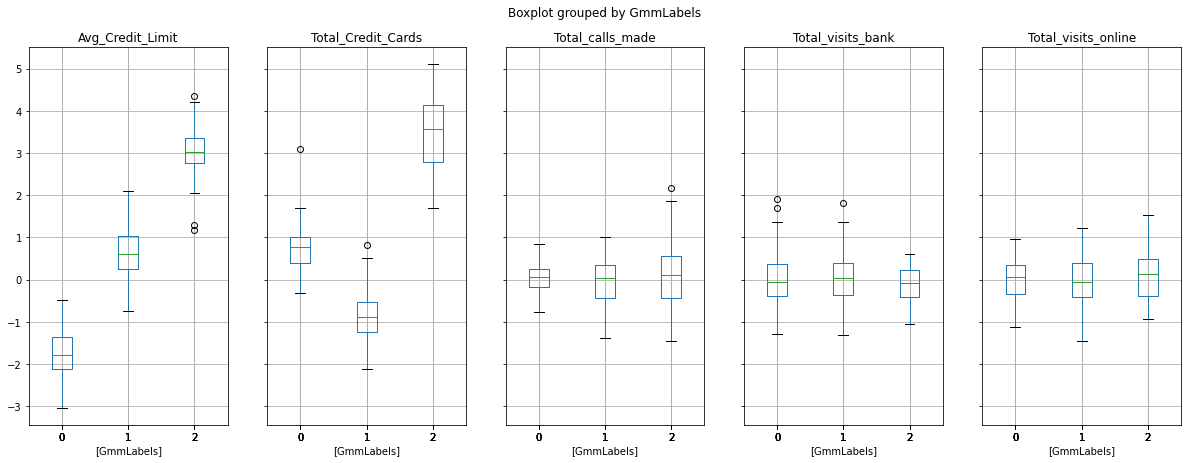

In [24]:
# Plotting boxplots with the new GMM based labels

features_with_lables = ["Avg_Credit_Limit", "Total_Credit_Cards", "Total_visits_bank", "Total_visits_online", "Total_calls_made", "GmmLabels"]

data_copy[features_with_lables].boxplot(by = 'GmmLabels', layout = (1, 5),figsize = (20, 7))

plt.show()

### K-Medoids

In [25]:
# Applying K-Medoids algorithm on the pca components
kmedo = KMedoids(n_clusters = 3, random_state = 1)

kmedo.fit(data_pca)

data_copy['kmedoLabels'] = kmedo.predict(data_pca)

data['kmedoLabels'] = kmedo.predict(data_pca)

In [26]:
# Number of observations in each cluster
data.kmedoLabels.value_counts()

2    289
0    222
1    133
Name: kmedoLabels, dtype: int64

In [27]:
# Calculating summary statistics of the original data for each label
mean = data.groupby('kmedoLabels').mean()

median = data.groupby('kmedoLabels').median()

df_kmedoids = pd.concat([mean, median], axis = 0)

df_kmedoids.index = ['group_0 Mean', 'group_1 Mean', 'group_2 Mean', 'group_0 Median', 'group_1 Median', 'group_2 Median']

df_kmedoids[original_features].T

,group_0 Mean,group_1 Mean,group_2 Mean,group_0 Median,group_1 Median,group_2 Median
Avg_Credit_Limit,12216.216216,85052.631579,28449.826990,12000.0,68000.0,20000.0
Total_Credit_Cards,2.423423,7.030075,5.363322,2.0,7.0,5.0
Total_visits_bank,0.950450,1.691729,3.830450,1.0,2.0,4.0
Total_visits_online,3.554054,4.639098,0.982699,4.0,2.0,1.0
Total_calls_made,6.878378,1.969925,1.851211,7.0,2.0,2.0


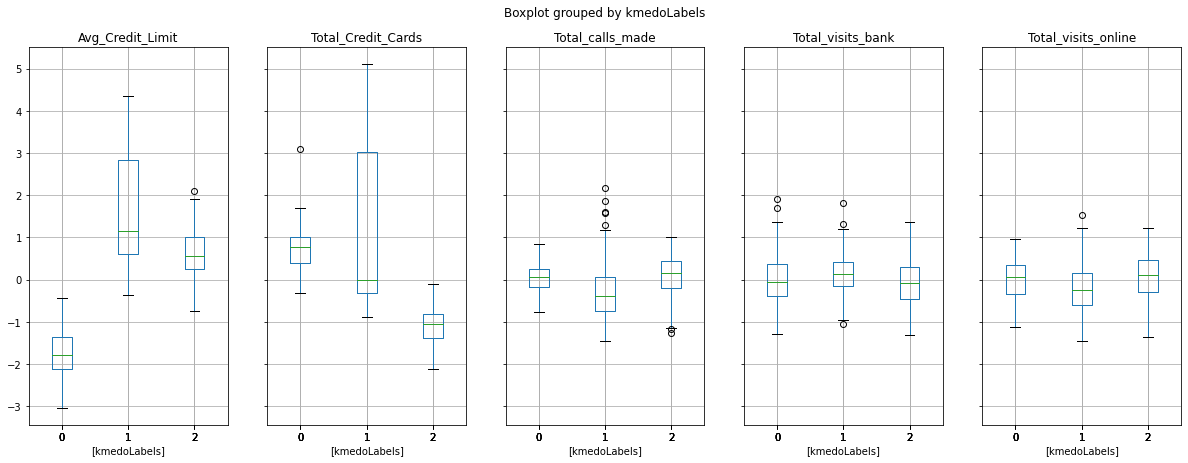

In [28]:
# Plotting boxplots with the new K-Medoids based labels

features_with_lables = ["Avg_Credit_Limit", "Total_Credit_Cards", "Total_visits_bank", "Total_visits_online", "Total_calls_made", "kmedoLabels"]

data_copy[features_with_lables].boxplot(by = 'kmedoLabels', layout = (1, 5), figsize = (20, 7))

plt.show()